1. Попробуйте изменить параметры нейронной сети работающей с датасетом imdb так, чтобы улучшить ее точность. Приложите анализ.

In [36]:
from __future__ import print_function

import numpy as np
import tensorflow as tf

from keras.utils import pad_sequences, to_categorical
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Activation
from keras.datasets import imdb
from tensorflow.keras.layers import LSTM, SimpleRNN, GRU
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

In [13]:
max_features = 20000

# обрезание текстов после данного количества слов (среди top max_features наиболее используемые слова)
maxlen = 80
batch_size = 50

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features, oov_char=2,skip_top=6)

print('Pad последовательности (примеров в x единицу времени)')
x_train_ex = pad_sequences(x_train, maxlen=maxlen)
x_test_ex = pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train_ex.shape)
print('x_test shape:', x_test_ex.shape)
print(x_train_ex[0])

Pad последовательности (примеров в x единицу времени)
x_train shape: (25000, 80)
x_test shape: (25000, 80)
[   15   256     2     2     7  3766     2   723    36    71    43   530
   476    26   400   317    46     7     2 12118  1029    13   104    88
     2   381    15   297    98    32  2071    56    26   141     6   194
  7486    18     2   226    22    21   134   476    26   480     2   144
    30  5535    18    51    36    28   224    92    25   104     2   226
    65    16    38  1334    88    12    16   283     2    16  4472   113
   103    32    15    16  5345    19   178    32]


In [14]:
model = Sequential()
model.add(Embedding(max_features, 128)) # input_dim, output_dim
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# стоит попробовать использовать другие оптимайзер и другие конфигурации оптимайзеров 
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

hh = model.fit(x_train_ex, y_train,
          batch_size=batch_size,
          epochs=1, # увеличьте при необходимости
          validation_data=(x_test_ex, y_test))
score, acc = model.evaluate(x_test_ex, y_test,
                            batch_size=batch_size)
print('Результат при тестировании:', score)
print('Тестовая точность:', acc)

500/500 [==============================] - 36s 73ms/step - loss: 0.3742 - accuracy: 0.8320
Результат при тестировании: 0.37417253851890564
Тестовая точность: 0.8319600224494934


In [95]:
# Попробуем прежде всего изменить параметры обрезания текста

max_len_new = 160

x_train_new = pad_sequences(x_train, maxlen=maxlen)
x_test_new = pad_sequences(x_test, maxlen=maxlen)

In [96]:
size = 32
opt = tf.keras.optimizers.Adamax(learning_rate=0.0001, beta_1 = 0.90, beta_2 = 0.990)

model_2 = Sequential()
model_2.add(Embedding(max_features, 128))
model_2.add(LSTM(128, dropout=0.20))#, recurrent_dropout=0.30))
model_2.add(Dense(1, activation='sigmoid'))

model_2.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

hh_2 = model_2.fit(x_train_new, y_train,
          batch_size=size,
          epochs=16, 
          validation_data=(x_test_new, y_test))
score, acc = model_2.evaluate(x_test_new, y_test,
                            batch_size=size)
print('Результат при тестировании:', score)
print('Тестовая точность:', acc)

Epoch 1/16
782/782 [==============================] - 17s 19ms/step - loss: 0.6623 - accuracy: 0.6059 - val_loss: 0.5965 - val_accuracy: 0.6816
Epoch 2/16
782/782 [==============================] - 14s 18ms/step - loss: 0.5458 - accuracy: 0.7258 - val_loss: 0.5010 - val_accuracy: 0.7549
Epoch 3/16
782/782 [==============================] - 14s 18ms/step - loss: 0.4699 - accuracy: 0.7779 - val_loss: 0.4510 - val_accuracy: 0.7884
Epoch 4/16
782/782 [==============================] - 14s 18ms/step - loss: 0.4249 - accuracy: 0.8063 - val_loss: 0.4327 - val_accuracy: 0.8007
Epoch 5/16
782/782 [==============================] - 14s 17ms/step - loss: 0.3975 - accuracy: 0.8216 - val_loss: 0.4062 - val_accuracy: 0.8122
Epoch 6/16
782/782 [==============================] - 15s 19ms/step - loss: 0.3756 - accuracy: 0.8359 - val_loss: 0.3908 - val_accuracy: 0.8230
Epoch 7/16
782/782 [==============================] - 14s 18ms/step - loss: 0.3590 - accuracy: 0.8424 - val_loss: 0.4096 - val_accuracy:

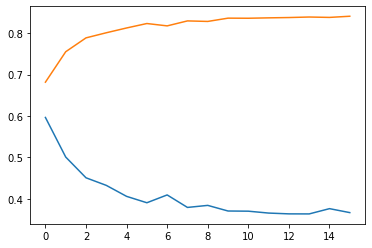

In [97]:
plt.plot(hh_2.history['val_loss'])
plt.plot(hh_2.history['val_accuracy'])

Выводы:

Для ускорения обучения сети в условиях невозможности оплатить время работы GPU на Colab, пришлось отказаться от использования параметра recurrent_dropout в LSTM-слое, чтобы получить возможность обучать модель с применением оптимизированного ядра из пакета cudaNN на локальной машине. Впрочем, выглядит так, что это не повлияло на результаты.

1) При использовании оптимизатора Adam увеличение количества эпох ведёт к переобучению модели и снижению точности на валидационном наборе.

2) Замена оптимизатора на Adamax улучшило ситуацию с переобучением, хотя и не искоренило проблему в целом - при обучении на протяжении более чем 16 эпох переобучение вновь становится заметным.

3) Увеличение длины, по которой обрезается текст в 2 раза (с 80 до 160), дало небольшой прирост в точности. Дальнейшее увеличение этого параметра не оказало никакого влияния.

4) batch_size = 32 показывает лучший баланс между скоростью обучения и точностью, по сравнению с исходным значением (50). Увеличение размера батча более 64 ведёт к заметному ухудшению точности

5) Прочие попытки улучшить точность, такие как добавление регуляризации, использование других оптимизаторов, подбор параметров оптимизаторов и изменение количества нейронов в полносвязном слое, результатов не дали.

В целом, получить заметно более точные результаты не удалось. Наилучшая попытка представлена выше, но и её точность (около 84%) отличается от точности исходной модели в пределах погрешности от разных весов при инициализации.
    